In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle
import kipoiseq
from itertools import combinations
import scipy
import pyBigWig
import os
from statannotations.Annotator import Annotator

2023-11-21 13:38:19.189479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cre_size = 5000

In [3]:
model = custom_model.Enformer()

2023-11-21 13:39:01.629239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 13:39:02.581809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 69493 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:85:00.0, compute capability: 8.0


In [4]:
cell_line_data = {'K562': {'ENCFF413AHU': 'DNase', 'ENCFF381NDD': 'H3K27ac'}}

In [5]:
cres = pd.read_csv('../results/sufficiency_test//enformer_selected_cres.csv')

In [6]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Silencer vs. Enhancer: Mann-Whitney-Wilcoxon test two-sided, P_val:2.881e-09 U_stat=1.831e+05


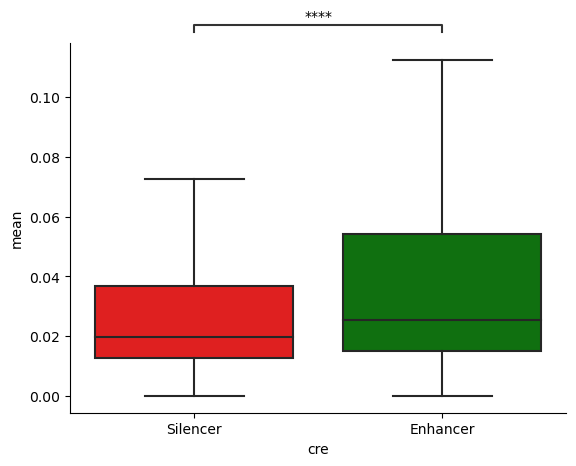

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Silencer vs. Enhancer: Mann-Whitney-Wilcoxon test two-sided, P_val:5.963e-09 U_stat=1.839e+05


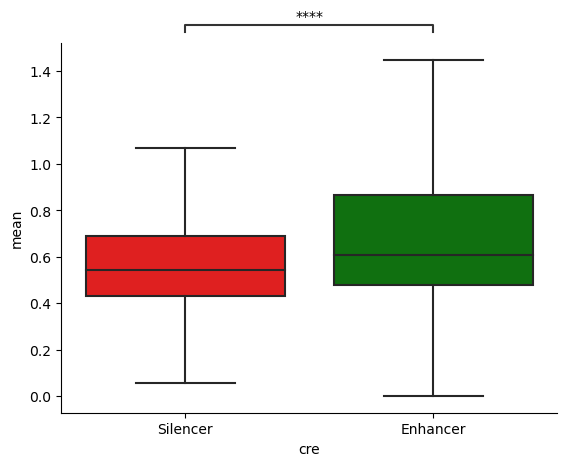

In [12]:
x='cre'
y='mean'
for cell, data_ids in cell_line_data.items():
    cell_df = cres[cres['cell_line']==cell]

    for bw_id, label in data_ids.items():
        bw = pyBigWig.open(f'../data/{bw_id}.bigWig')
        chromatin_marks = []
        for cre_type, df in cell_df.groupby('tile class'): 
            vals = []
            for i, row in df.iterrows():
                chrom, tss = row['seq_id'].split('_')[1:3]
                seq_start = int(tss) - model.seq_length//2
                cre_start = seq_start + row['tile_start']
                cre_end = cre_start + cre_size
        
                vals.append(bw.values(chrom, cre_start, cre_end))
            chromatin_marks_per_cre = pd.DataFrame.from_dict({y: np.array(vals).mean(axis=-1)})
            chromatin_marks_per_cre[x] = cre_type
            chromatin_marks.append(chromatin_marks_per_cre)
            
        chromatin_marks = pd.concat(chromatin_marks)
        pairs = ['Enhancer', 'Silencer']
        order = ['Silencer', 'Enhancer']
        
        ax = sns.boxplot(data=chromatin_marks, x=x, y=y, order=order, showfliers=False, palette={'Enhancer':'g', 'Silencer':'r'})
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        pairs=[("Enhancer", "Silencer")]
        
        annotator = Annotator(ax, pairs, data=chromatin_marks, x=x, y=y, order=order)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
        annotator.apply_and_annotate()
        plt.show()
        
        